# Problem 1

## Gillespie's Algorithm

### Classes

In [141]:
class Population:
    def __init__(self, initial_X, initial_Y, initial_Z):
        self.X = initial_X
        self.Y = initial_Y
        self.Z = initial_Z

    def __str__(self):
        return f"X = {self.X}, Y = {self.Y}, Z = {self.Z}"

    def N(self):
        return self.X + self.Y + self.Z

class Gillespie_Parameters:
    def __init__(self, population: Population, beta, gamma, mu):
        self.population = population
        self.beta = beta
        self.gamma = gamma
        self.mu = mu

class Event:
    def __init__(self, name, rate_function, result_function):
        self.name = name
        self.rate_function = rate_function
        self.result_function = result_function

    def get_rate(self, params: Gillespie_Parameters):
        return self.rate_function(params)
    
    def execute_result(self, population: Population):
        return self.result_function(population)

### Define the events

In [142]:


def _birth_rate(params: Gillespie_Parameters):
    return params.mu * params.population.N()
def _birth_result(pop: Population) -> Population:
    pop.X += 1
BirthEvent = Event('birth', _birth_rate, _birth_result)

def _transmission_rate(params: Gillespie_Parameters):
    return params.beta * params.population.X * params.population.Y / params.population.N()
def _transmission_result(pop: Population) -> Population:
    pop.X -= 1
    pop.Y += 1
TransmissionEvent = Event('transmission', _transmission_rate, _transmission_result)

def _recovery_rate(params: Gillespie_Parameters):
    return params.gamma * params.population.Y
def _recovery_result(pop: Population) -> Population:
    pop.Y -= 1
    pop.Z += 1
RecoveryEvent = Event('recovery', _recovery_rate, _recovery_result)

def _death_x_rate(params: Gillespie_Parameters):
    return params.mu * params.population.X
def _death_x_result(pop: Population) -> Population:
    pop.X -= 1
DeathXEvent = Event('death_x', _death_x_rate, _death_x_result)

def _death_y_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Y
def _death_y_result(pop: Population) -> Population:
    pop.Y -= 1
DeathYEvent = Event('death_y', _death_y_rate, _death_y_result)

def _death_z_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Z
def _death_z_result(pop: Population) -> Population:
    pop.Z -=1
DeathZEvent = Event('death_z', _death_z_rate, _death_z_result)

events = [BirthEvent, TransmissionEvent, RecoveryEvent, DeathXEvent, DeathYEvent, DeathZEvent]

### Prepare Gillespie Simulation

In [143]:
import numpy as np

def get_rates(events: list[Event], params: Gillespie_Parameters):
    return [e.get_rate(params) for e in events]

def get_delta_ts(rates: list[float]):
    rands = np.random.rand(len(rates))
    while 0 in rands: # avoid zeros
        rands = np.random.rand(len(rates))
    delta_ts = np.full(len(rates), np.inf)
    for i, r in enumerate(rates):
        if r == 0:
            continue
        delta_ts[i] = (-1 / r) * np.log(rands[i])
    return delta_ts


def gillespie(params: Gillespie_Parameters, events: list[Event], t_max):
    t = 0.0
    params
    results = [[], [], [], []] # t, X, Y, Z
    while t < t_max:
        y_prev = params.population.Y
        rates = get_rates(events, params)
        delta_ts = get_delta_ts(rates)
        event_index = np.argmin(delta_ts)
        t += delta_ts[event_index]
        events[event_index].execute_result(params.population)
        if params.population.Y == 0 and y_prev != 0:
            print(f'Extinction at t={t}')
        results[0].append(t)
        results[1].append(params.population.X)
        results[2].append(params.population.Y)
        results[3].append(params.population.Z)
        # print(f'{events[event_index].name}: X = {params.population.X}, Y = {params.population.Y}, Z = {params.population.Z}, N = {params.population.N()}, t = {t}')
    return results

# Helper Functions

In [144]:
def standardize_timesteps(data, interval, max_t):
    t_list = np.array(data[0])
    new_t_list = np.arange(0, max_t, interval)

    result = np.zeros((len(data), len(new_t_list)))
    result[0] = new_t_list
    for i in range(1, len(data)):
        result[i] = np.interp(new_t_list, t_list, data[i])

    return result

### Run Gillespie

R0 = 7.996870109546166
Extinction at t=168.2456135498496


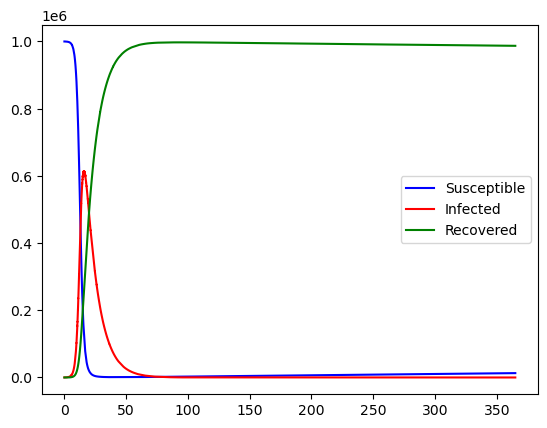

In [145]:
import matplotlib.pyplot as plt

population_size = 1e6
initial_infected = 100
initial_population = Population(population_size - initial_infected, initial_infected, 0)
beta = 0.8
gamma = 0.1
mu = 1 / (70*365)
sim_length = 365
data_interval = 1

r0 = beta / (gamma + mu)
print(f'R0 = {r0}')

params = Gillespie_Parameters(initial_population, beta, gamma, mu)
res = gillespie(params, events, sim_length)
res_standardized = standardize_timesteps(res, data_interval, sim_length)

plt.plot(res[0], res[1], 'b', label='Susceptible')
plt.plot(res[0], res[2], 'r', label='Infected')
plt.plot(res[0], res[3], 'g', label='Recovered')
plt.legend(loc='right')
plt.show()